## Data exploration

This notebook does a simple exploration of the available data. Our project is a Kaggle competition, so the data comes directly from them. Therefore there is no need for a data acquisition section since we simply downloaded all. 

In [2]:
from PIL import Image
import tensorflow as tf
import numpy as np
import scipy.misc
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
from SimpleCV import *

In [3]:
fish_classes = ['ALB','BET','DOL','LAG','OTHER','SHARK','YFT','NoF']
number_classes = len(fish_classes)
main_path_train = '../train'
main_path_test = '../test_stg1'

Firstly some of the images are shown to see what type of data we have.

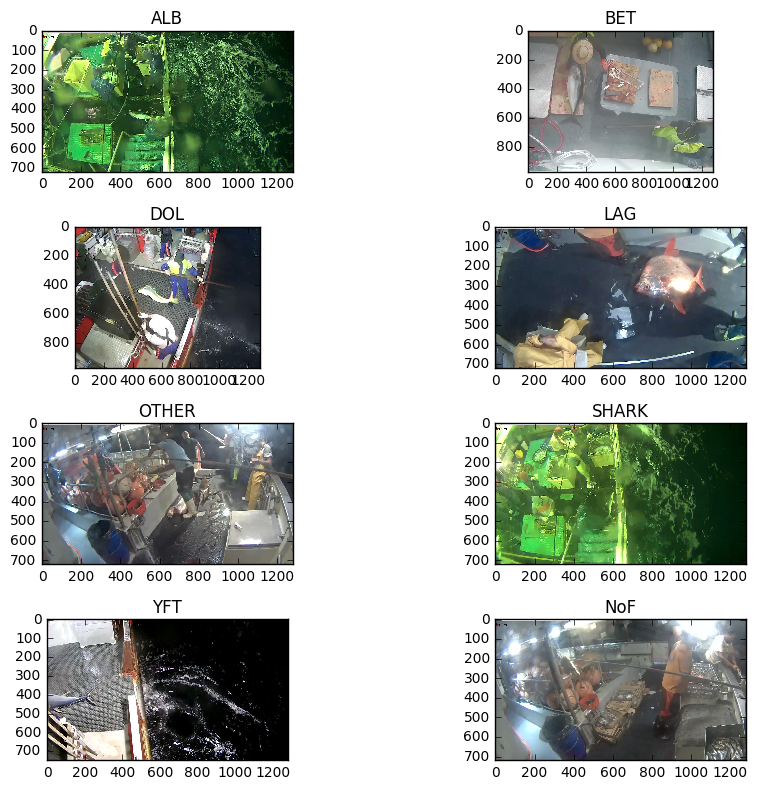

In [5]:
iteration = 0
for classes in fish_classes:
    iteration = iteration + 1
    path = os.path.join(main_path_train,classes)
    images_path = os.listdir(path)
    #print(images_path)
    number_images = len(images_path)
    random_number = np.random.randint(0,number_images)
    im = scipy.misc.imread(os.path.join(path,images_path[random_number]))
    plt.subplot(4,2,iteration)
    plt.imshow(im)
    plt.title(classes)

plt.tight_layout()



It can be seen that most part of the images have nothing to do with the fish itself. Images are quite different between each other depending on where the camera is located in the boat. The same type of fish might be in different boats and therefore have very different images. So using the entire image as an input of a CNN does not seem like a good idea. Instead our approach consists on finding the fish and cropping it out. Then we can feed our CNN with the smaller image, which should be easier to classify.

Other aspect to consider is the fact that some images are taken during the day and others are taken during the night. This might affect the classification if the CNN takes colors as features because the same fish will have very different color depending on whether the picture is taken during daytime or nightime. We are going to compare three approaches to see which one gives better results. The first one is just not taking this into account and classify the fishes regardless of the illumination. The second one is to convert the images into black and white so that the colors don't longer affect. The third one is to build two different classifiers: one for daylight and the other for nightlight. This will probably give the best accuracy, but we will need much more training samples.

So we should now see how many samples we have for each fish specie. The following script plots a bar chart with the number of images of each class:

Number of train images for ALB: 1719
Number of train images for BET: 200
Number of train images for DOL: 117
Number of train images for LAG: 67
Number of train images for OTHER: 299
Number of train images for SHARK: 176
Number of train images for YFT: 734
Number of train images for NoF: 465
Number of test images: 1000


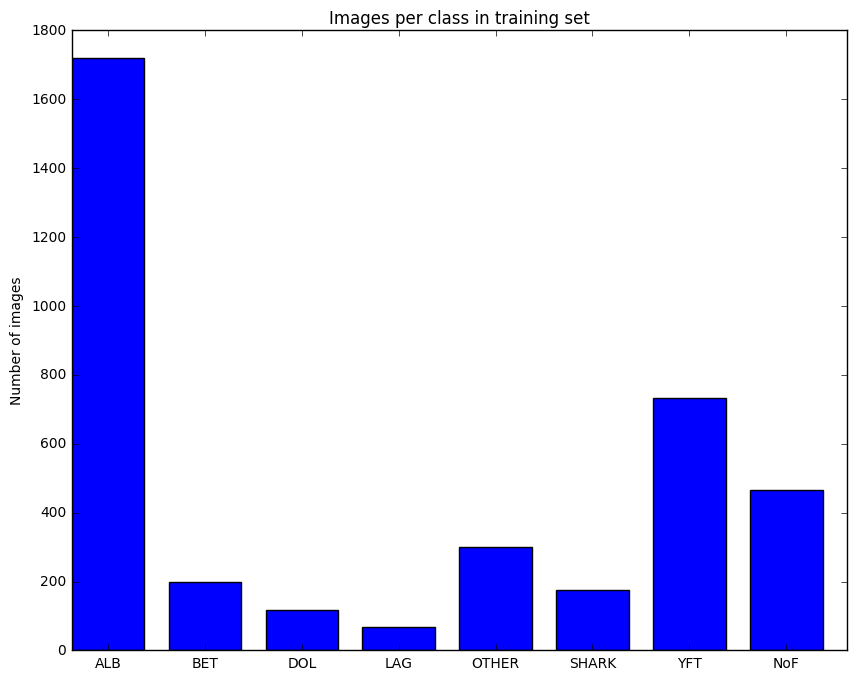

In [4]:
number_images_train = []
for classes in fish_classes:
    path_train = os.path.join(main_path_train,classes)
    number_im_class = len(os.listdir(path_train))
    number_images_train.append(number_im_class)
    print 'Number of train images for '+classes+': '+str(number_im_class)

number_images_test = len(os.listdir(main_path_test))
print 'Number of test images: '+str(number_images_test)

width = 0.75
ind = np.arange(number_classes)
plt.bar(ind,number_images_train,width,color='blue')
plt.ylabel('Number of images')
plt.title('Images per class in training set')
plt.xticks(ind + width/2.,fish_classes)
plt.show()

It can be seen that data is highly unbalanced since there is a class with 1719 samples and other class with just 67 samples. We will deal with this by combining over-sampling for the less frequent classes with under-sampling for the more frequent classes. However this might limit the third possibility discussed earlier regarding the nigh images. With so few samples of some classes, it will be hard to have enough data for training two CNNs.

However, differenciating between day and night can be very useful to detect the fish because we can use two different templates. So, now we will show how to do this. Fisrtly a few examples of each are shown:


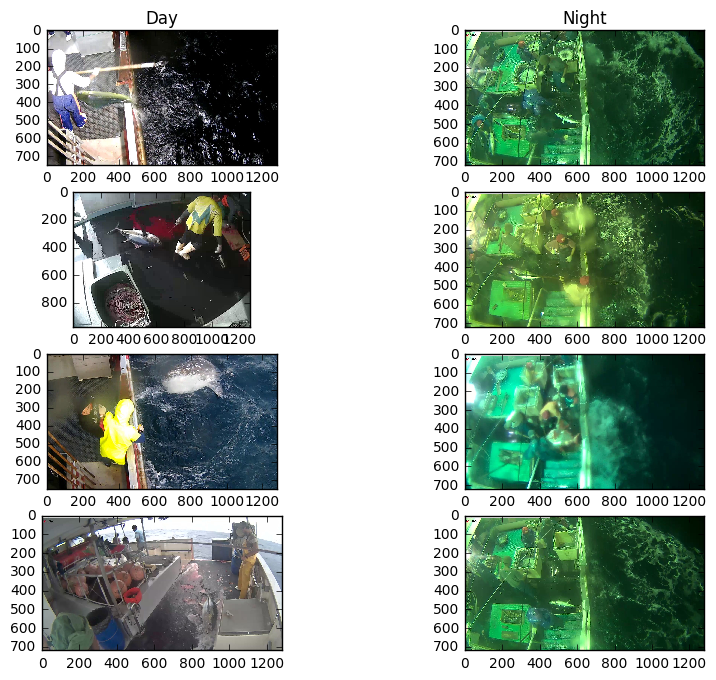

In [6]:
image_day1 = os.path.join(main_path_train,'DOL/img_00348.jpg')
image_night1 = os.path.join(main_path_train,'SHARK/img_00033.jpg')
image_day2 = os.path.join(main_path_train,'BET/img_02343.jpg')
image_night2 = os.path.join(main_path_train,'BET/img_00883.jpg')
image_day3 = os.path.join(main_path_train,'OTHER/img_00126.jpg')
image_night3 = os.path.join(main_path_train,'LAG/img_02089.jpg')
image_day4 = os.path.join(main_path_train,'YFT/img_00021.jpg')
image_night4 = os.path.join(main_path_train,'YFT/img_00092.jpg')
images = [image_day1,image_night1,image_day2,image_night2,image_day3,image_night3,image_day4,image_night4]

iteration = 0
for image in images:
    iteration = iteration + 1
    im = scipy.misc.imread(image)
    plt.subplot(4,2,iteration)
    plt.imshow(im)
    if iteration == 1:
        plt.title('Day')
    if iteration == 2:
        plt.title('Night')

A first impression is that night images are considerably greener than day images. We can check this by extracting the RGB average for each image:

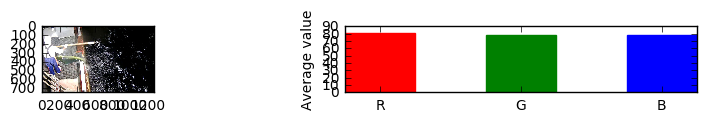

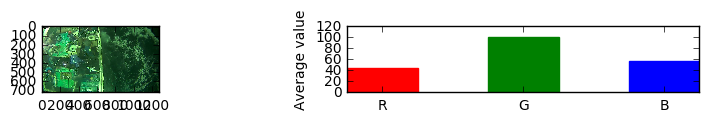

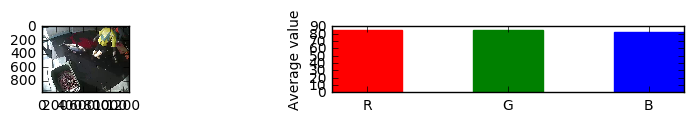

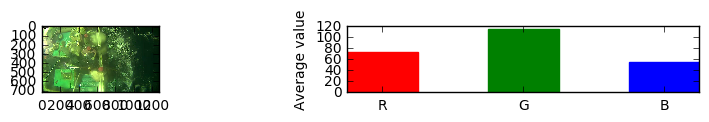

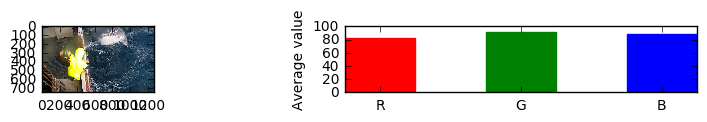

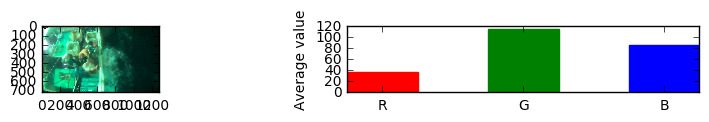

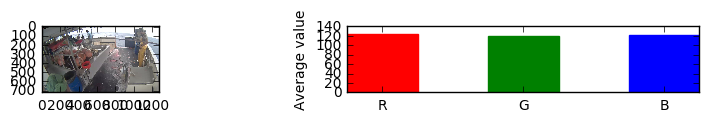

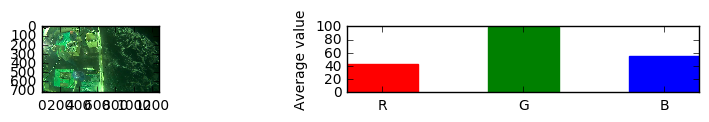

In [7]:
def get_RGB_averages(image):
    r = np.mean(image[:,:,0])
    g = np.mean(image[:,:,1])
    b = np.mean(image[:,:,2])
    return [r,g,b] 

iteration = 0
width = 0.5
for image in images:
    iteration = iteration + 1
    im = scipy.misc.imread(image)
    plt.subplot(8,2,iteration)
    plt.imshow(im)
    [r,g,b] = get_RGB_averages(im)
    ind = np.arange(3)
    iteration = iteration + 1
    plt.subplot(8,2,iteration)
    bars = plt.bar(ind,[r,g,b],width)
    bars[0].set_color('r')
    bars[1].set_color('g')
    bars[2].set_color('b')
    plt.xticks(ind + width/2.,['R','G','B'])
    plt.ylabel('Average value')
    plt.show()

Indeed it can be seen that for day images the three components have a similar value, while in night images the green component is always larger than the other two. This means we can build a classifier based on this to classify images into day or night.  K-means is used using the three dimensional data of each color component

In [ ]:
# Get RGB data of all the images to find the average and also to classify them afterwards
data_rgb = []
for classes in fish_classes:
    path = os.path.join(main_path_train,classes)
    for image in os.listdir(path):
        image_path = os.path.join(path,image)
        im = scipy.misc.imread(image_path)
        [r,g,b] = get_RGB_averages(im)
        data_rgb.append([r,g,b])
        
#Build the K-means model
X = data_rgb
kmeans = KMeans(n_clusters=2).fit(X)
directory = '../train_daynight_cut'
if not os.path.exists(directory):
    os.makedirs(directory)

#Classify every image in a cluster
for classes in fish_classes:
    path = os.path.join(main_path_train,classes)
    direc = directory+'/'+classes
    if not os.path.exists(direc):
        os.makedirs(direc)
        os.makedirs(direc+'/Day')
        os.makedirs(direc+'/Night')
    for image in os.listdir(path):
        image_path = os.path.join(path,image)
        im = scipy.misc.imread(image_path)
        [r,g,b] = get_RGB_averages(im)
        cluster = kmeans.predict([r,g,b])
        ima = Image(image_path)
        if cluster == 0: #Day
            #(im_name,a) = image.split('.jp')
            ima.save(direc+'/Day/' + image)
        if cluster == 1: #Night
            ima.save(direc+'/Night/' + image)

The next step is to detect the fish and crop it. This will be done in other notebook. There is no need of exploring the size of the original images because we are not going to use them directly. The input of the CNN is going to be the cropped image of the fish, which will be resized to a certain value to ensure that all are the same. So, we don't care about the initial size of the images.